# Guava Fruit Disease Detection using Convolutional Neural Networks

This notebook demonstrates the use of Convolutional Neural Networks (CNNs) for detecting and classifying diseases in guava fruits. The dataset used in this notebook is the **Guava Fruit Disease Dataset** from Kaggle, which includes three classes: [**Anthracnose**](https://www.maine.gov/dacf/php/gotpests/diseases/anthracnose.htm#:~:text=Anthracnose%20is%20a%20group%20of,attacks%20only%20specific%20tree%20species.), [**Fruit Fly**](https://www.fruitfly.co.za/sanitation-and-host-plants/#:~:text=All%20fruit%20fly%2Dinfested%20and,infestation%20and%20should%20be%20removed.), and **Healthy Guava**.

The dataset can be accessed from the following link: [Guava Fruit Disease Dataset on Kaggle](https://www.kaggle.com/datasets/asadullahgalib/guava-disease-dataset/code?datasetId=6003511).

Key tasks covered in this notebook:
- Data loading and preprocessing
- Image augmentation for improved generalization
- Training a CNN model
- Evaluating model performance using accuracy, precision, recall, F1-score, and confusion matrix

![Cover Image](sample_images.png)


## Import Libraries

In [ ]:
# !pip install -r requirements.txt

In [70]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tabulate import tabulate
import seaborn as sns
import pandas as pd
import numpy as np
import random
import os

## Set Paths

In [56]:
# Set the dataset paths
base_dir = "archive/GuavaDiseaseDataset/GuavaDiseaseDataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")


## Dataset Summary

### Sample Images

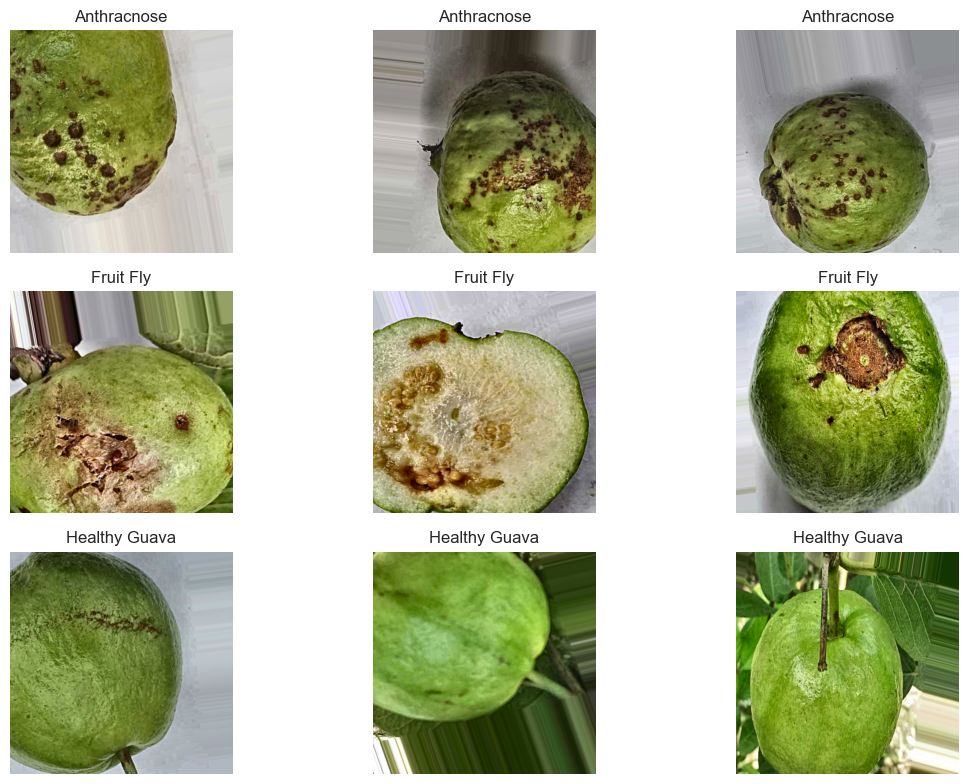

In [64]:

# Define class labels and their directories
class_dirs = {
    'Anthracnose': os.path.join(train_dir, 'Anthracnose'),
    'Fruit Fly': os.path.join(train_dir, 'fruit_fly'),
    'Healthy Guava': os.path.join(train_dir, 'healthy_guava')
}

# Number of images to display per class
num_images = 3

# Create a figure with 3 rows and 3 columns for the images
fig, axes = plt.subplots(3, num_images, figsize=(12, 8))

# Function to load and display images
def display_images(class_name, row_idx):
    class_dir = class_dirs[class_name]
    
    # Randomly select 'num_images' from the class directory
    images = random.sample(os.listdir(class_dir), num_images)
    
    for i, image_name in enumerate(images):
        # Load image
        img_path = os.path.join(class_dir, image_name)
        img = mpimg.imread(img_path)
        
        # Plot the image on the corresponding subplot
        axes[row_idx, i].imshow(img)
        axes[row_idx, i].axis('off')  # Turn off axes
        axes[row_idx, i].set_title(class_name)

# Display images for each class
display_images('Anthracnose', 0)
display_images('Fruit Fly', 1)
display_images('Healthy Guava', 2)

# Adjust the layout for better display
plt.tight_layout()
plt.savefig('sample_images.png')
plt.show()


### Dataset Distribution

C:\Users\Brian\AppData\Local\Temp\ipykernel_1300\117189528.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plot = sns.barplot(


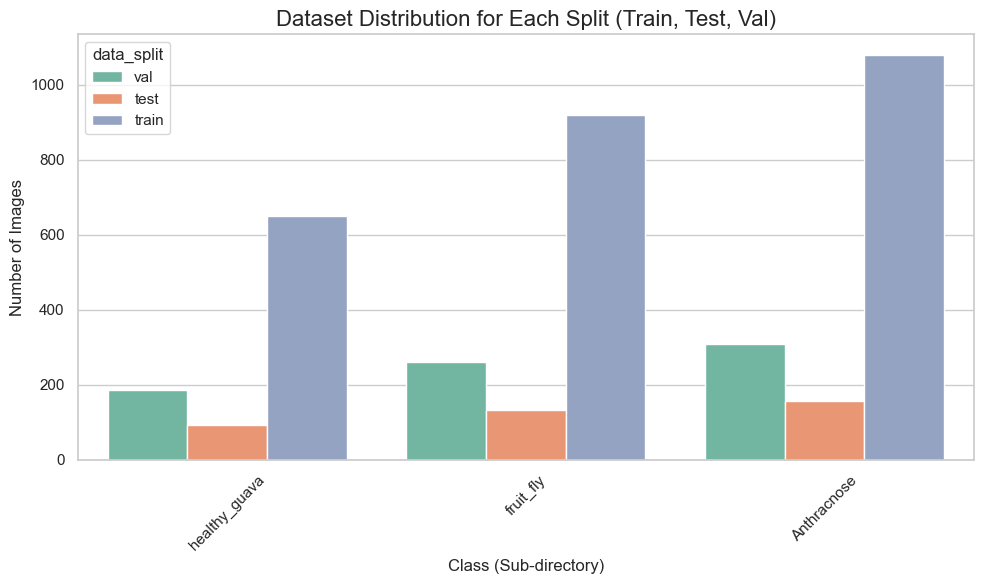

In [65]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv('archive/dataset_summary.csv')

# Set up the visualization style
sns.set(style="whitegrid")

# Create a bar plot to show the distribution of image counts across splits and classes
plt.figure(figsize=(10, 6))
plot = sns.barplot(
    data=df, 
    x='sub_directory', 
    y='image_count', 
    hue='data_split', 
    ci=None, 
    palette='Set2'
)

# Add titles and labels
plot.set_title('Dataset Distribution for Each Split (Train, Test, Val)', fontsize=16)
plot.set_xlabel('Class (Sub-directory)', fontsize=12)
plot.set_ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig('dataset_distribution.png')
plt.show()


## Data Augmentation and Image Preprocessing

This section prepares the dataset for training, validation, and testing by utilizing `ImageDataGenerator` from TensorFlow/Keras. Key steps include:

1. **Data Augmentation for Training Data**:
   - Rescaling pixel values to the range [0, 1] using `rescale=1.0/255`.
   - Applying random transformations to enhance dataset diversity:
     - **Rotation**: Random rotations up to 20 degrees.
     - **Width and Height Shifts**: Random shifts up to 20% of the image dimensions.
     - **Shear and Zoom**: Random shearing and zooming transformations.
     - **Horizontal Flip**: Randomly flipping images horizontally.

2. **Normalization for Validation and Test Data**:
   - Rescaling pixel values to [0, 1] without additional augmentations to maintain consistency for evaluation.

3. **Image Loading and Preprocessing**:
   - Images and their corresponding labels are loaded from the specified directories (`train_dir`, `val_dir`, and `test_dir`).
   - All images are resized to 150x150 pixels for compatibility with the model.
   - Data is provided in batches of 32 images, with `class_mode='categorical'` to handle multi-class classification.
   - Test data is not shuffled to ensure proper evaluation of predictions.

These generators ensure the model is trained with a diverse set of inputs and evaluated on consistent, unaltered test data.


In [32]:
# Define ImageDataGenerators for data augmentation and normalization
train_datagen = ImageDataGenerator(rescale=1.0/255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load images and labels from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize images to 150x150
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No shuffling for evaluation
)


Found 2647 images belonging to 3 classes.
Found 755 images belonging to 3 classes.
Found 382 images belonging to 3 classes.


## Defining the Convolutional Neural Network (CNN)

This section defines the architecture of the CNN model using the Keras Sequential API. The model includes:

- **Convolutional and Pooling Layers**:
  - Three convolutional layers with ReLU activation, each followed by max-pooling layers to reduce spatial dimensions.
  - The number of filters increases progressively (32, 64, 128) to capture more complex features.

- **Flattening and Fully Connected Layers**:
  - A flattening layer to convert 2D feature maps into a 1D vector.
  - A dense layer with 128 neurons and ReLU activation.
  - A dropout layer to reduce overfitting by randomly disabling 50% of the neurons during training.

- **Output Layer**:
  - A dense layer with 3 neurons (corresponding to the 3 classes: Anthracnose, Fruit Fly, and Healthy Guava) and softmax activation for multi-class classification.


In [33]:
model = models.Sequential([
    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten and Dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes
])


c:\Users\Brian\OneDrive - University of Witwatersrand\Desktop\off_the_grid\tutorials\computer_vision\guava_fruit_disease_detection\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Compiling the Model

In [34]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


## Training the Model

In this step, the model is trained using the training data (`train_generator`) and validated on the validation data (`val_generator`) over 50 epochs. The training process involves:

In [35]:
history = model.fit(
    train_generator,
    epochs=50,  # Adjust epochs based on your needs
    validation_data=val_generator
)


c:\Users\Brian\OneDrive - University of Witwatersrand\Desktop\off_the_grid\tutorials\computer_vision\guava_fruit_disease_detection\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 48s 560ms/step - accuracy: 0.3935 - loss: 1.1391 - val_accuracy: 0.6490 - val_loss: 0.6484
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 50s 604ms/step - accuracy: 0.6637 - loss: 0.7315 - val_accuracy: 0.6781 - val_loss: 0.8040
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 54s 649ms/step - accuracy: 0.8034 - loss: 0.5270 - val_accuracy: 0.8252 - val_loss: 0.4021
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 53s 644ms/step - accuracy: 0.8510 - loss: 0.3940 - val_accuracy: 0.8212 - val_loss: 0.4386
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 53s 639ms/step - accuracy: 0.8782 - loss: 0.3400 - val_accuracy: 0.8013 - val_loss: 0.5003
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 53s 636ms/step - accuracy: 0.9046 - loss: 0.2575 - val_accuracy: 0.8424 - val_loss: 0.4181
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 53s 645ms/step - accuracy: 0.9075 - loss: 0.2498 - val_accuracy: 0.9113 - val_loss: 0.2533
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 52s 623ms/step - accuracy: 0.9301 - loss: 0.1950 - val_accu

## Visualize Training Perfomance

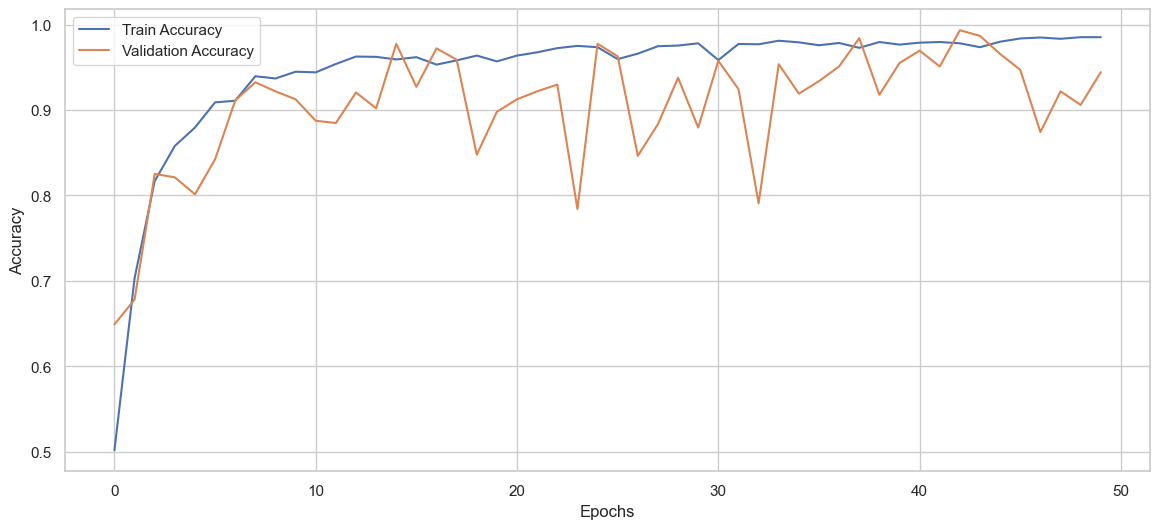

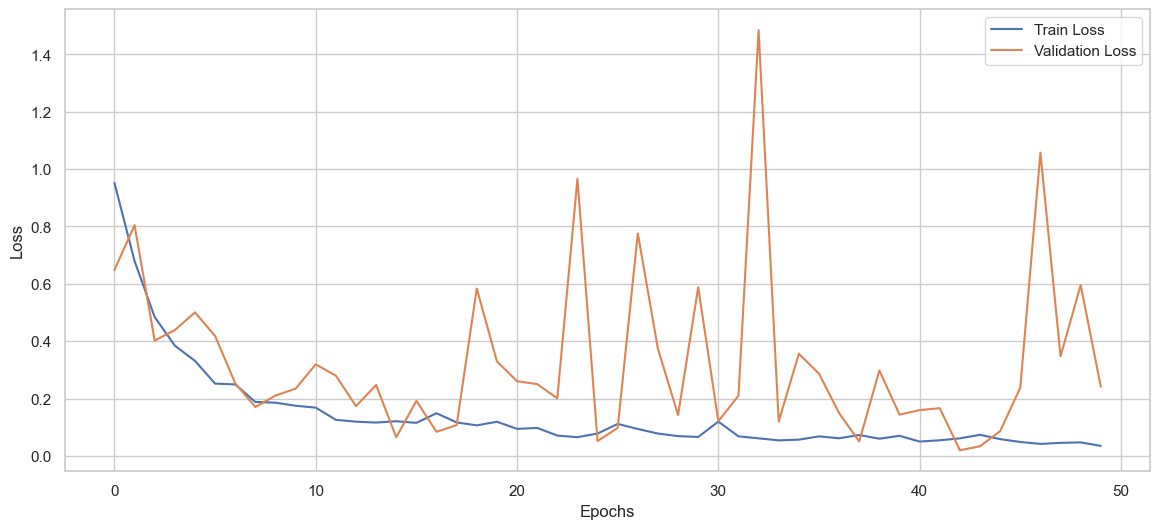

In [75]:
# Plot accuracy
plt.figure(figsize=(14, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

# Plot loss
plt.figure(figsize=(14, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()


## Evaluating the Model

In [45]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

# Get predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Predicted labels
true_classes = test_generator.classes  # True labels
class_labels = list(test_generator.class_indices.keys())  # Class names



12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.9320 - loss: 0.4912
Test Loss: 0.29
Test Accuracy: 0.95
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step


### Classification Report

In [74]:
# Generate a detailed classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

# Convert the report into a list of rows for tabulation
report_table = []
for label, metrics in report.items():
    if label != 'accuracy':  # Exclude the accuracy row, we handle it separately
        row = [label] + [round(metrics['precision'], 2), round(metrics['recall'], 2), round(metrics['f1-score'], 2), metrics['support']]
        report_table.append(row)

# Add accuracy as a separate row
accuracy_row = ['accuracy', round(report['accuracy'], 2), '', '', '']
report_table.append(accuracy_row)

# Print the formatted classification report using tabulate
headers = ['Class', 'Precision', 'Recall', 'F1-Score', 'Support']
print("Classification Report:")
print(tabulate(report_table, headers=headers, floatfmt=".2f", tablefmt="rounded_grid"))

Classification Report:
╭───────────────┬─────────────┬──────────┬────────────┬───────────╮
│ Class         │   Precision │ Recall   │ F1-Score   │ Support   │
├───────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Anthracnose   │        0.99 │ 0.92     │ 0.95       │ 156.0     │
├───────────────┼─────────────┼──────────┼────────────┼───────────┤
│ fruit_fly     │        0.89 │ 0.99     │ 0.94       │ 132.0     │
├───────────────┼─────────────┼──────────┼────────────┼───────────┤
│ healthy_guava │        0.99 │ 0.94     │ 0.96       │ 94.0      │
├───────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg     │        0.95 │ 0.95     │ 0.95       │ 382.0     │
├───────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg  │        0.95 │ 0.95     │ 0.95       │ 382.0     │
├───────────────┼─────────────┼──────────┼────────────┼───────────┤
│ accuracy      │        0.95 │          │            │           │
╰───────────────┴────────

### Confusion Matrix

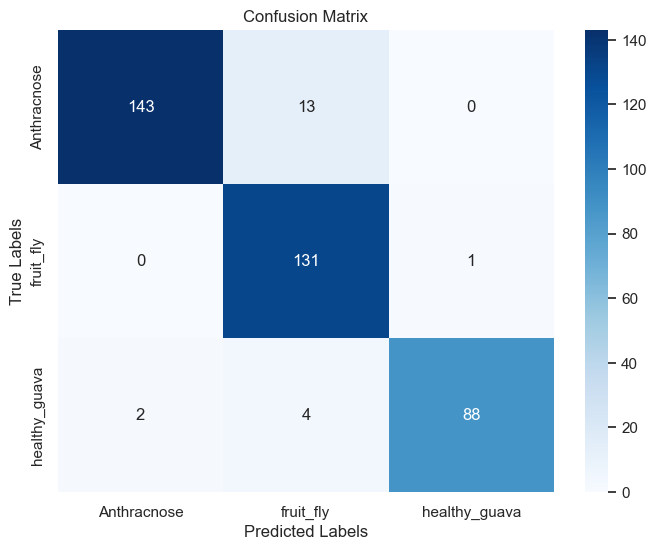

In [66]:
# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()


## Save and Load the Model

In [49]:
# Save the model
model.save('guava_disease_cnn.h5')

# Load the model (optional)
loaded_model = tf.keras.models.load_model('guava_disease_cnn.h5')


## Make Predictions

In [50]:
# Predict on test data
predictions = loaded_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print some sample predictions
for i in range(382):
    print(f"True class: {class_labels[true_classes[i]]}, Predicted: {class_labels[predicted_classes[i]]}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step
True class: Anthracnose, Predicted: Anthracnose
True class: Anthracnose, Predicted: Anthracnose
True class: Anthracnose, Predicted: Anthracnose
True class: Anthracnose, Predicted: Anthracnose
True class: Anthracnose, Predicted: Anthracnose
True class: Anthracnose, Predicted: Anthracnose
True class: Anthracnose, Predicted: Anthracnose
True class: Anthracnose, Predicted: Anthracnose
True class: Anthracnose, Predicted: Anthracnose
True class: Anthracnose, Predicted: Anthracnose
True class: Anthracnose, Predicted: Anthracnose
True class: Anthracnose, Predicted: Anthracnose
True class: Anthracnose, Predicted: Anthracnose
True class: Anthracnose, Predicted: Anthracnose
True class: Anthracnose, Predicted: Anthracnose
True class: Anthracnose, Predicted: Anthracnose
True class: Anthracnose, Predicted: Anthracnose
True class: Anthracnose, Predicted: Anthracnose
True class: Anthracnose, Predicted: Anthracnose
True class: Anthracnose, Predicted: Anthracnose